In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from func import display_df, path, path_img, get_data
from func_torch import ShopeeDataset, device, torch, f1_score_cal
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
import gc
import faiss

In [2]:
# input
df = get_data(path / 'train.csv', path_img)
df.head()

,posting_id,image,image_phash,title,label_group,filepath,target,title_edit
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,/Users/kevin/OneDrive - Seagroup/computer_viso...,"[train_2278313361, train_129225211]",paper bag victoria secret
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,/Users/kevin/OneDrive - Seagroup/computer_viso...,"[train_3423213080, train_3386243561]","double tape 3m vhb 12 mm x 4,5 m original / do..."
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,/Users/kevin/OneDrive - Seagroup/computer_viso...,"[train_3803689425, train_2288590299]",maling tts canned pork luncheon meat 397 gr
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,/Users/kevin/OneDrive - Seagroup/computer_viso...,"[train_2406599165, train_3342059966]",daster batik lengan pendek - motif acak / camp...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,/Users/kevin/OneDrive - Seagroup/computer_viso...,"[train_3369186413, train_921438619]",nescafe \xc3\x89clair latte 220ml


In [3]:
dataset_data = ShopeeDataset(csv=df, train=True)
data_loader = DataLoader(dataset_data, batch_size=16, num_workers=4)

print(f"Dataset Len: {len(dataset_data):,}\nImage Shape [0]: {dataset_data[0][0].shape}")

Dataset Len: 34,250
Image Shape [0]: torch.Size([3, 512, 512])


In [4]:
model_name = 'efficientnet-b3'
image_embeddings_path = path / f'image_embed_{model_name}.npy'
rerun = False

if rerun:
    # Run
    model_effnet = EfficientNet.from_name(model_name).to(device)

    print(model_name, device)

    embeddings = []
    with torch.no_grad():
        for image, label in tqdm(data_loader):
            image = image.to(device)
            img_embeddings = model_effnet(image)
            img_embeddings = img_embeddings.detach().cpu().numpy()
            embeddings.append(img_embeddings)
    all_image_embeddings = np.concatenate(embeddings)

    # Save
    np.save(image_embeddings_path, all_image_embeddings)

    # Clean memory
    del model_effnet
    _ = gc.collect()

else:
    # load
    all_image_embeddings = np.load(image_embeddings_path)

print(f"image_embeddings shape: {all_image_embeddings.shape}")

image_embeddings shape: (34250, 1000)


In [5]:
nb, d = all_image_embeddings.shape 

In [6]:
# ivfflat
nlist = 100
k = 4
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)

# flat
# index = faiss.IndexFlatL2(d)
# index.add(all_image_embeddings)

# nlist = 100
# m = 8
# k = 4
# quantizer = faiss.IndexFlatL2(d)  # this remains the same
# index = faiss.IndexIVFPQ(quantizer, d, nlist, m, 8)# 8 specifies that each sub-vector is encoded as 8 bits
# index.train(all_image_embeddings)
# index.add(all_image_embeddings)
# print(index.is_trained, index.ntotal)

In [ ]:
index.train(all_image_embeddings)

In [ ]:
assert not index.is_trained
index.train(all_image_embeddings.astype('float32'))
assert index.is_trained

In [30]:
k = 50
D, I = index.search(all_image_embeddings[1].reshape(1, -1), k)  # search
print(I)

[[    1  3688  1112  4004 34158  5050 13474  9739 22155 32332 19319 17606
  31516 26421 11476 19863 27639 16920 31823 29098 19451 16267 31616  4725
   4960 22040 23873 24856 21688 23563 16327  3258 15911 28552 28604  2312
  14399 25108  8672 14259  6392  9671 27766  3718 26870 26847 15421   894
  29673 24896]]


In [31]:
D

array([[ 0.      , 18.781788, 18.84821 , 19.21428 , 19.240103, 19.25461 ,
        19.271584, 19.276258, 19.32314 , 19.340374, 19.358995, 19.365602,
        19.397036, 19.431238, 19.452038, 19.458668, 19.48765 , 19.492565,
        19.545664, 19.585434, 19.598763, 19.638756, 19.653309, 19.678062,
        19.701168, 19.701515, 19.710571, 19.717743, 19.719076, 19.783947,
        19.79195 , 19.805882, 19.806192, 19.807243, 19.809242, 19.816628,
        19.819292, 19.825916, 19.846905, 19.859058, 19.865387, 19.916386,
        19.930185, 19.939941, 19.978079, 19.979145, 19.980167, 20.024393,
        20.031324, 20.047026]], dtype=float32)

In [32]:
df[['posting_id', 'filepath', 'title']].iloc[I[0]]

,posting_id,filepath,title
1,train_3386243561,/Users/kevin/OneDrive - Seagroup/computer_viso...,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO..."
3688,train_3908607237,/Users/kevin/OneDrive - Seagroup/computer_viso...,650Ml Follow Me Followme Green Tea Shampoo Con...
1112,train_1664676684,/Users/kevin/OneDrive - Seagroup/computer_viso...,Goggle Mask Kacamata Masker Helm Motor Retro B...
4004,train_1478384315,/Users/kevin/OneDrive - Seagroup/computer_viso...,Sepatu Pria Kasual SLip on Adidas UNO Sepatu M...
34158,train_4221982820,/Users/kevin/OneDrive - Seagroup/computer_viso...,Sprei Lady Rose 180x200 King terlaris Keroppi
5050,train_1779706050,/Users/kevin/OneDrive - Seagroup/computer_viso...,TOOL BOX SET KOPER - MAINAN ANAK TUKANG TUKAN...
13474,train_1778494836,/Users/kevin/OneDrive - Seagroup/computer_viso...,Dapur Ijah Bumbu Opor 50gr
9739,train_1196801594,/Users/kevin/OneDrive - Seagroup/computer_viso...,TISSUE NICE 180 SHEET 2PLY TERMURAH/TISU NICE...
22155,train_1955891964,/Users/kevin/OneDrive - Seagroup/computer_viso...,Kain katun jepang toyobo ori japan RM - Seri 1
32332,train_2576234944,/Users/kevin/OneDrive - Seagroup/computer_viso...,(Termurah) Wardah Intense Matte Lipstick 05 Ea...


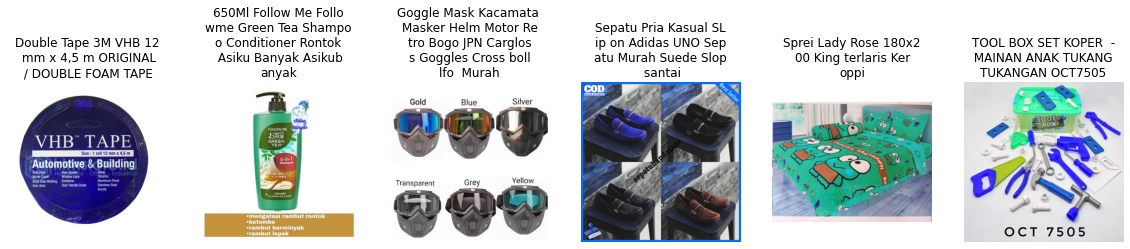

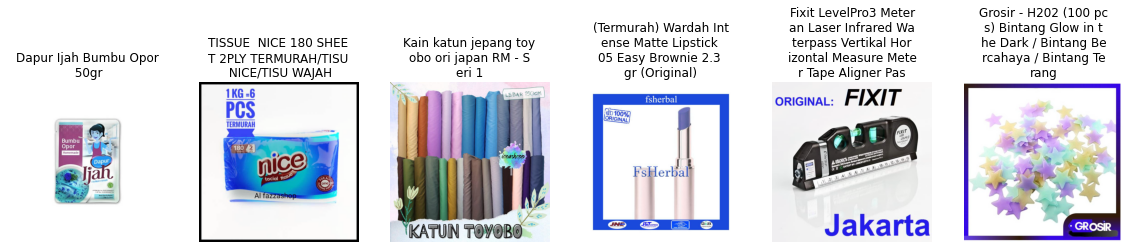

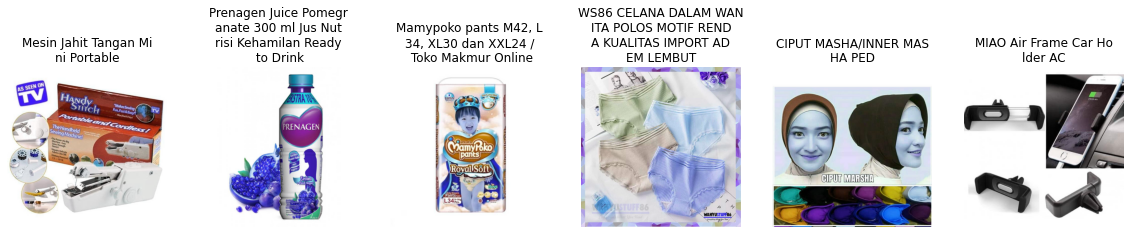

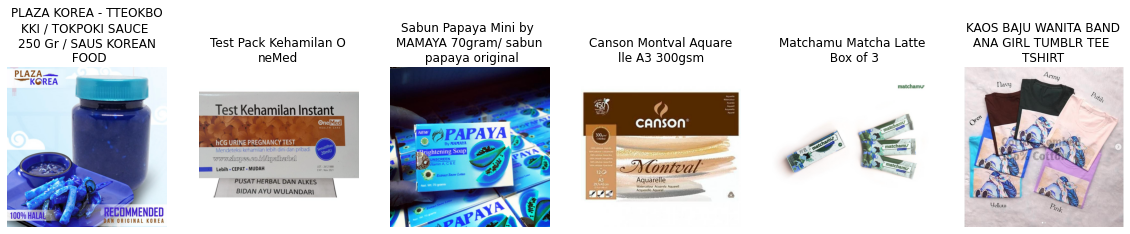

In [33]:
display_df(df[['posting_id', 'filepath', 'title']].iloc[I[0]], path_img)

In [ ]:
tmp = pd.DataFrame(df.query(f'posting_id == "{test_id}"')['img_pred'].item(), columns=['posting_id'])
tmp = tmp.merge(df[['posting_id', 'filepath', 'title']], how='left')

display_df(tmp, path_img)

In [5]:
nb, d = all_image_embeddings.shape
nq = 34250
xb = np.random.random((nb, d)).astype('float32')
xb[:, 0] += np.arange(nb) / 1000.
xq = np.random.random((nq, d)).astype('float32')
xq[:, 0] += np.arange(nq) / 1000.

# use a single GPU
res = faiss.StandardGpuResources()  
# Using a flat index, build a flat (CPU) index
index_flat = faiss.IndexFlatL2(d)
# make it a flat GPU index
gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat)
gpu_index_flat.add(xb)         # add vectors to the index

print(gpu_index_flat.ntotal)
k = 10
distances, indices = gpu_index_flat.search(xq, k)

AttributeError: module 'faiss' has no attribute 'StandardGpuResources'

In [ ]:
index = faiss.IndexFlatL2(all_image_embeddings.shape[1])
index.add(all_image_embeddings)
print(index.ntotal)

k = 50
distances, indices = index.search(all_image_embeddings, k)

# faiss_index = faiss.IndexFlatL2(1000)
#
# im_indices = []
# for i, v in tqdm(enumerate(all_image_embeddings), total=all_image_embeddings.shape[0]):
#     faiss_index.add(v.reshape(1, 1000))
#     im_indices.append(i)

In [ ]:
thresholds = list(np.arange(3.0, 5.0, 0.1))
target = df['target'].values.tolist()
scores, plot_check, f1_score_lst, pred_lst = {}, {}, [], {}

for num in thresholds:
    predictions = []
    for k in range(all_image_embeddings.shape[0]):
        idx = np.where(distances[k,] < num)[0]
        ids = indices[k, idx]
        predictions.append(df['posting_id'].iloc[ids].values.tolist())
    f1_score_lst = [f1_score_cal(i, v) for i, v in zip(target, predictions)]

    score = np.mean(f1_score_lst)
    scores.update({num: score})
    plot_check.update({num: f1_score_lst})
    pred_lst.update({num: predictions})
    print(f'--- F1 score for threshold {num} is {score:.3f} ---\n')


best_score = max(scores, key=scores.get)
print(f'--- Best score is {round(scores[best_score], 4)} and has a threshold {best_score} ---')
df['img_pred'] = pred_lst[best_score]
df['f1_score'] = plot_check[best_score]

In [ ]:
df['posting_id'].iloc[indices[0]]